In [1]:
from research_env.misc.globals import *  # Project variables, paths to data, plotting utilities, etc.
from faculty_hiring.parse import load    # For loading DBLP records (CS)

In [2]:
load.load_all_publications(cs_faculty, DBLP_DIR)

## Number of publications before and after

In [5]:
Npre  = 5    # Within N1 years of first being hired.
Npost = 5    # Within N2 years *after* being hired.

for person in cs_faculty:
    start_year = person.first_asst_job_year
    career_length = 2012 - start_year
        
    person['pre_pubs'] = 0.
    person['post_pubs'] = 0.
    
    if 'dblp_pubs' in person:
        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None:
                if pub['year'] <= start_year and pub['year'] >= start_year - Npre:
                    person['pre_pubs'] += inflation_adjust(pub['year'])
                elif pub['year'] > start_year and pub['year'] <= start_year + Npost:
                    person['post_pubs'] += inflation_adjust(pub['year'])

#### Profile individuals along the following axes:
  * Placement year
  * PhD rank 
  * Productivity (pre-hire)
  * ~~Postdoctoral training~~
  * Gender (must be exact match)
  
Note: postdoctoral training should be encoded in productivity. Generally speaking, postdoctoral experience only appears to be beneficial to the extent that it allows the individual to boost their productivity.

In [57]:
profiles = np.zeros((len(cs_faculty), 4), dtype=np.float)
available = np.zeros(len(cs_faculty), dtype=int)

for i, person in enumerate(cs_faculty):
    profiles[i,0] = person.phd_rank
    profiles[i,1] = person.first_asst_job_year
    profiles[i,2] = person.pre_pubs
    profiles[i,3] = float(person.is_female)

## Maximum allowable caliper distances

We want to pick caliper distances c such that there's a significant difference in the two formed groups. First, what do the distributions of distances look like?

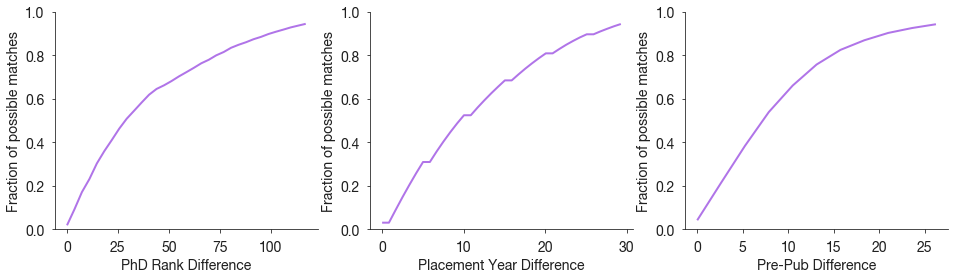

In [60]:
fig, axs = plt.subplots(1,3, figsize=(16, 4))

labels = ['PhD Rank Difference', 'Placement Year Difference', 'Pre-Pub Difference']

for a, ax in enumerate(axs):
    dimension = a 
    distances = []
    num_profiles = len(profiles)

    for i in xrange(num_profiles):
        for j in xrange(i+1, num_profiles):
            distances.append(np.abs(profiles[i,dimension]-profiles[j,dimension]))

    distances = np.array(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    rng_dist = np.linspace(min_dist, max_dist)
    denom = float(len(distances))

    curve = np.array([len(np.where(distances <= c)[0])/denom for c in rng_dist])
    keep = np.min(np.where(curve >= 0.95)[0])

    ax.plot(rng_dist[:keep], curve[:keep], color=ACCENT_COLOR_1, lw=LINE_WIDTH)
    finalize(ax)

    ax.set_ylabel('Fraction of possible matches')
    ax.set_ylim(0,1)
    ax.set_xlabel(labels[a])

plt.show()

#### For a set of specific caliper distances, how many matches can we make?

In [91]:
calipers = [5, 2, 1, 0]  # PhD rank, Placement Year, Pre-hire pubs, Gender (0=Male)
A = np.zeros((num_profiles, num_profiles), dtype=float)

for i in xrange(num_profiles):
    for j in xrange(i+1, num_profiles):
        diff = np.abs(profiles[i]-profiles[j])
        good = True
        for c, caliper in enumerate(calipers):
            if diff[c] > caliper:
                good = False
                break
                
        if good:
            A[i,j] = 1
print "Can make N=%d matches. (%.2f%% of all possible)" % (A.sum(), 100 * A.sum() / ((num_profiles*(num_profiles-1))/2))

Can make N=4309 matches. (0.13% of all possible)


In [92]:
def draw_matches(adjacency_matrix):
    matches = []
    A = adjacency_matrix.copy()
    
    while A.sum() > 0:
        rows, cols = np.where(A > 0)
        idx = np.random.choice(xrange(len(rows)))
        a, b = rows[idx], cols[idx]
        matches.append((a, b))
        A[a,:] = 0
        A[:,a] = 0
        A[b,:] = 0
        A[:,b] = 0
    
    return matches

In [93]:
matches = draw_matches(A)
num_matches = float(len(matches))
print 'Made %d matches.' % (num_matches)

Made 842 matches.


In [94]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = cs_faculty[a]
    person_b = cs_faculty[b]
    higher = np.argmin([cs_inst[person_a.first_asst_job_location]['pi'], cs_inst[person_b.first_asst_job_location]['pi']])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')

fraction: 0.565320665083
pvalue: 8.45190318454e-05


*** Sanity check #1 *** – how often is it the case that the person who started out more productive ended up being more productive in the long run?

In [102]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = cs_faculty[a]
    person_b = cs_faculty[b]
    
    # Skip if they have exactly the same number of publications before or after
    if person_a.pre_pubs == person_b.pre_pubs or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmax([person_a.pre_pubs, person_b.pre_pubs])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.505654281099
pvalue: 0.404727294248
N=619 (73.5% of total)


*** Sanity check #2 *** – how often is it the case that the person who trained at the more prestigious location also went on to become more productive?

In [103]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = cs_faculty[a]
    person_b = cs_faculty[b]
    
    # Skip if they have exactly the same rank, num pubs
    if person_a.phd_rank == person_b.phd_rank or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmin([person_a.phd_rank, person_b.phd_rank])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='greater')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.522727272727
pvalue: 0.129477961249
N=660 (78.4% of total)


*** Sanity check #3 *** – How often is it the case that the person who placed later was more productive?

In [104]:
count = 0.
total = 0.
diffs = []

for a, b in matches: 
    person_a = cs_faculty[a]
    person_b = cs_faculty[b]
    
    # Skip if they have exactly the same start year, num pubs
    if person_a.first_asst_job_year == person_b.first_asst_job_year or person_a.post_pubs == person_b.post_pubs:
        continue
    
    higher = np.argmax([person_a.first_asst_job_year, person_b.first_asst_job_year])
    prolif = np.argmax([person_a.post_pubs, person_b.post_pubs])
    
    if higher == 0: # Person A placed higher
        diffs.append(person_a.post_pubs - person_b.post_pubs)
    else:
        diffs.append(person_b.post_pubs - person_a.post_pubs)
    
    if higher == prolif:
        count += 1
    total += 1
    
print 'fraction:', count/total
print 'pvalue:', sp.stats.binom_test(count, total, 0.5, alternative='two-sided')
print 'N=%d (%.1f%% of total)' % (int(total), 100.*total/num_matches)

fraction: 0.492088607595
pvalue: 0.720373611101
N=632 (75.1% of total)
